Dataset shape: (541909, 8)

Dataset columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB

Summary statistics:
            Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min  

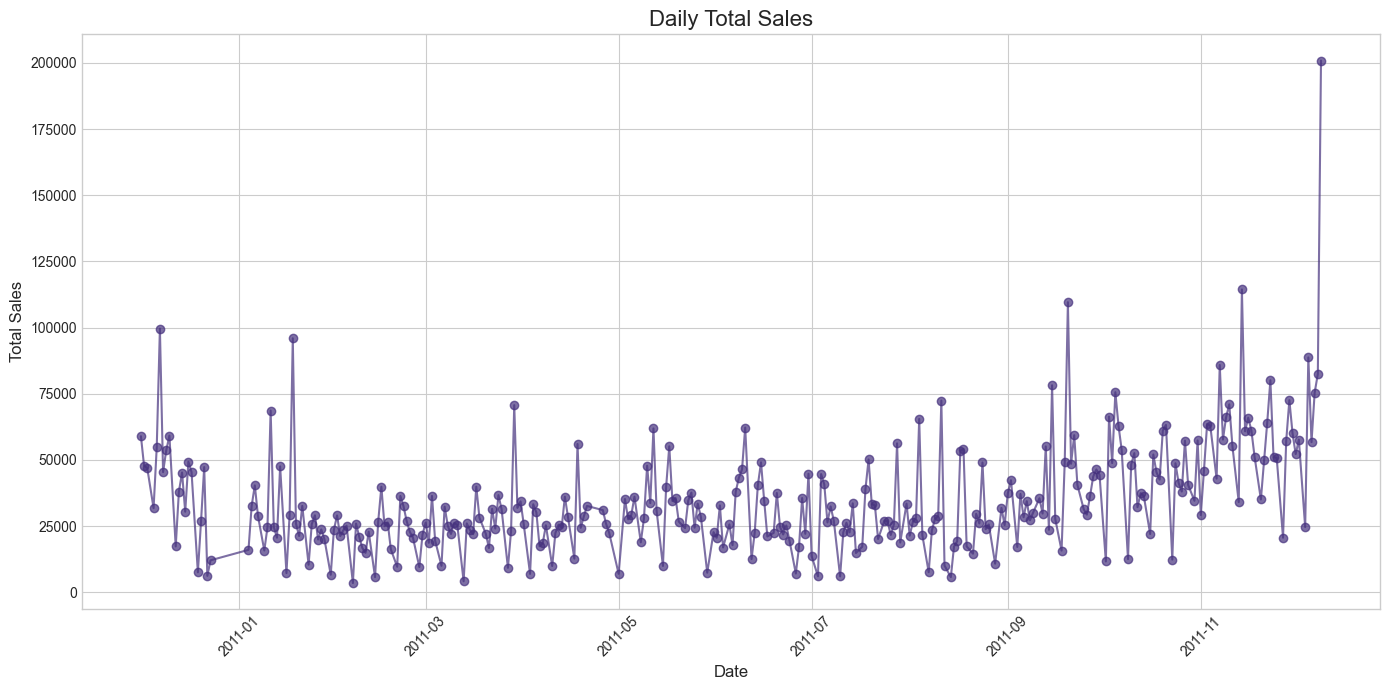

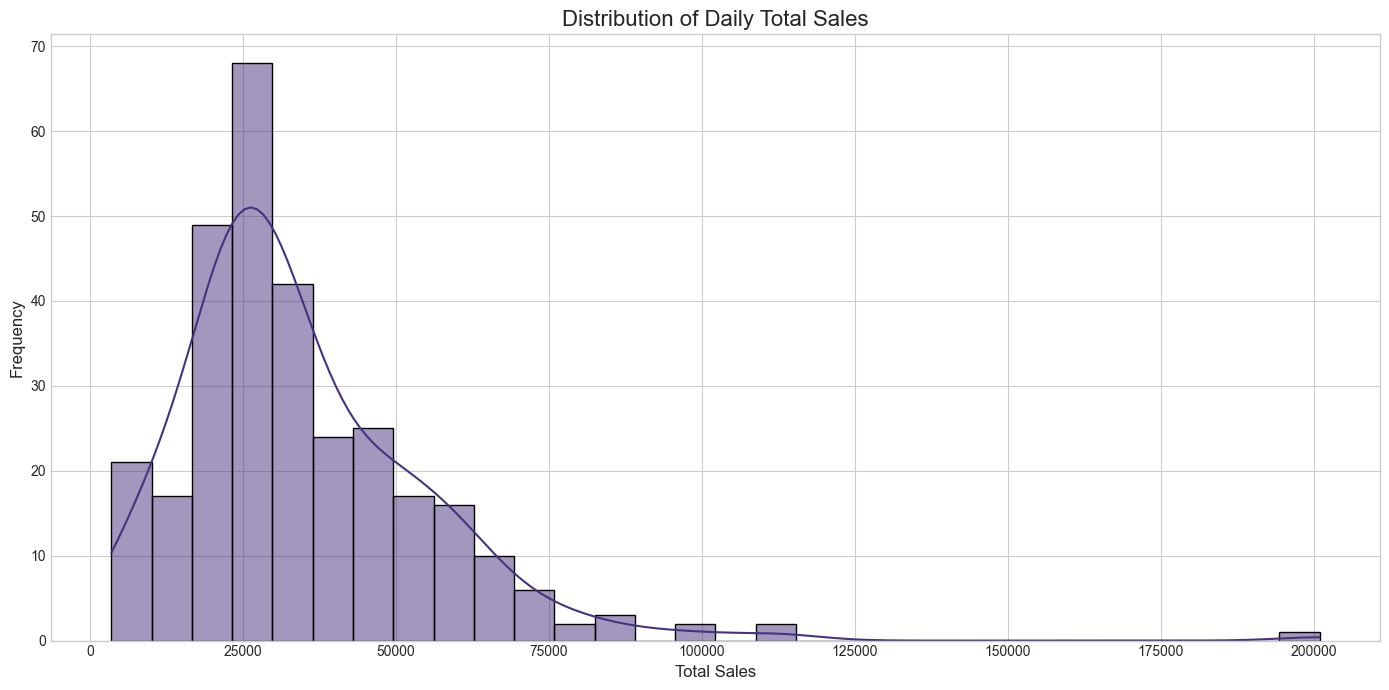

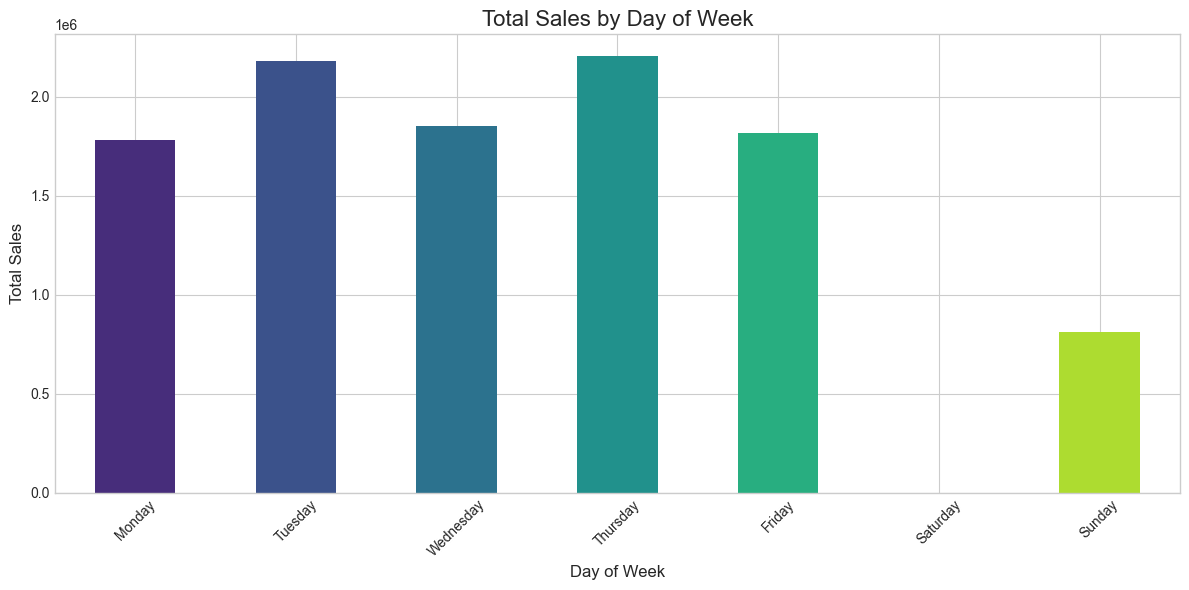

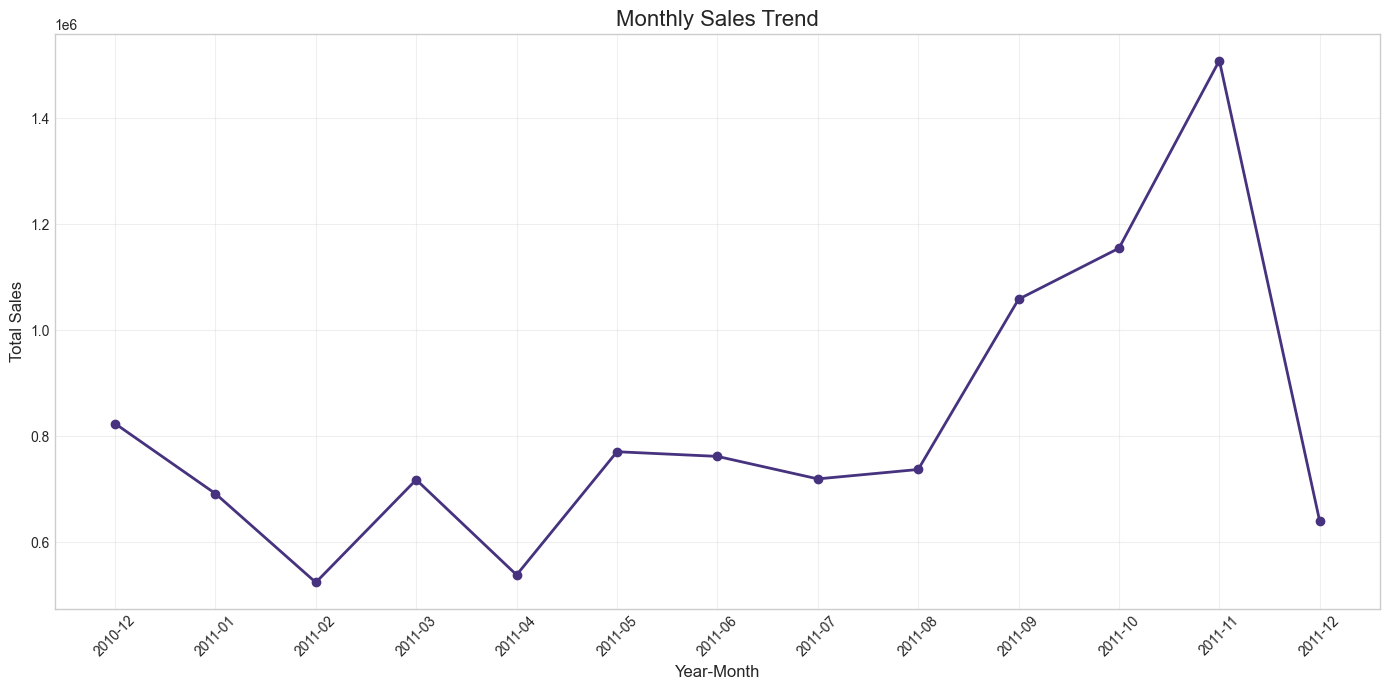


Training Ridge Regression...
Ridge Regression - Train RMSE: 9687.28, Test RMSE: 18206.32
Ridge Regression - Train MAE: 7037.12, Test MAE: 10771.70
Ridge Regression - Train R²: 0.61, Test R²: 0.55

Training Random Forest...
Random Forest - Train RMSE: 4601.96, Test RMSE: 22815.61
Random Forest - Train MAE: 3264.72, Test MAE: 14091.60
Random Forest - Train R²: 0.91, Test R²: 0.29

Training Gradient Boosting...
Gradient Boosting - Train RMSE: 2891.03, Test RMSE: 25995.55
Gradient Boosting - Train MAE: 2271.57, Test MAE: 17424.47
Gradient Boosting - Train R²: 0.97, Test R²: 0.08

Training SVR...
SVR - Train RMSE: 15696.54, Test RMSE: 39714.09
SVR - Train MAE: 10535.21, Test MAE: 30398.07
SVR - Train R²: -0.03, Test R²: -1.14

Training Neural Network...
Neural Network - Train RMSE: 23588.89, Test RMSE: 22715.16
Neural Network - Train MAE: 20264.07, Test MAE: 15339.93
Neural Network - Train R²: -1.33, Test R²: 0.30


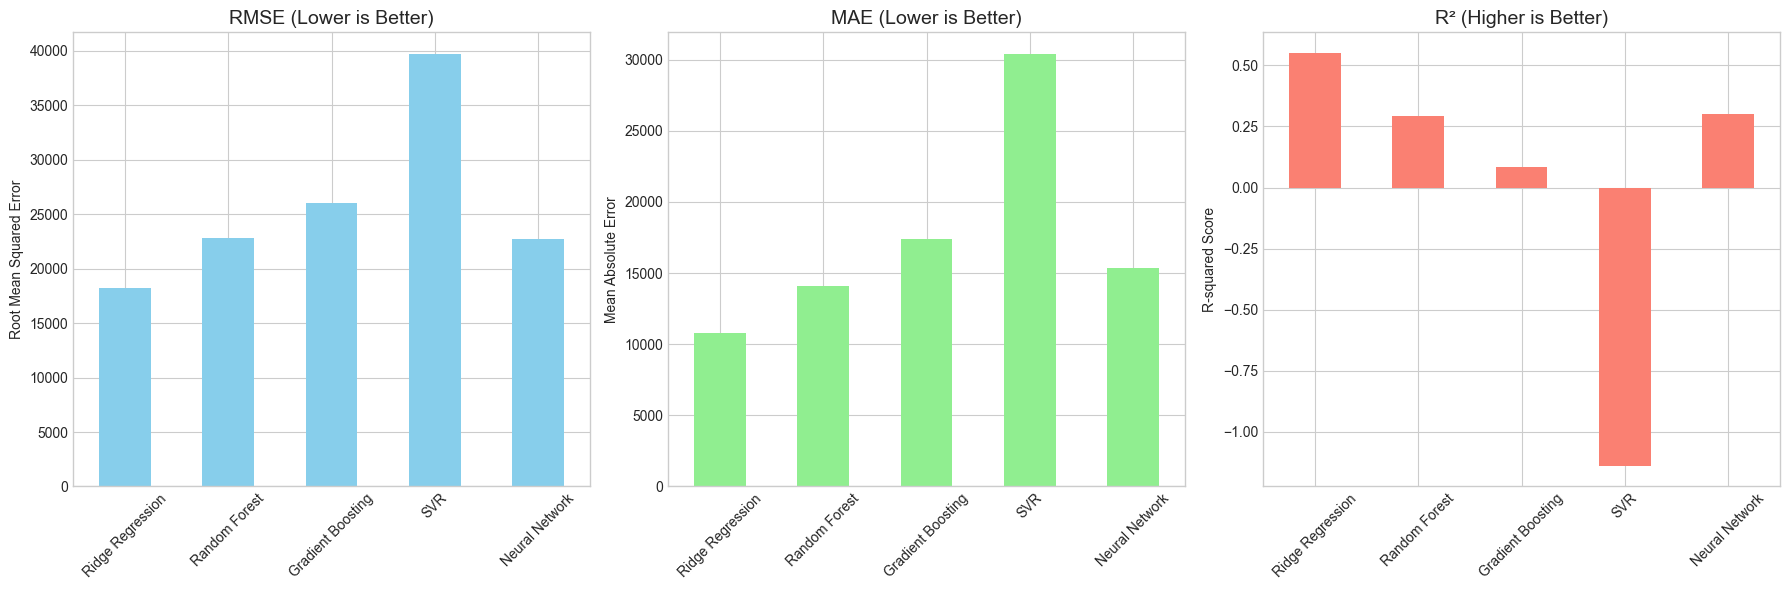

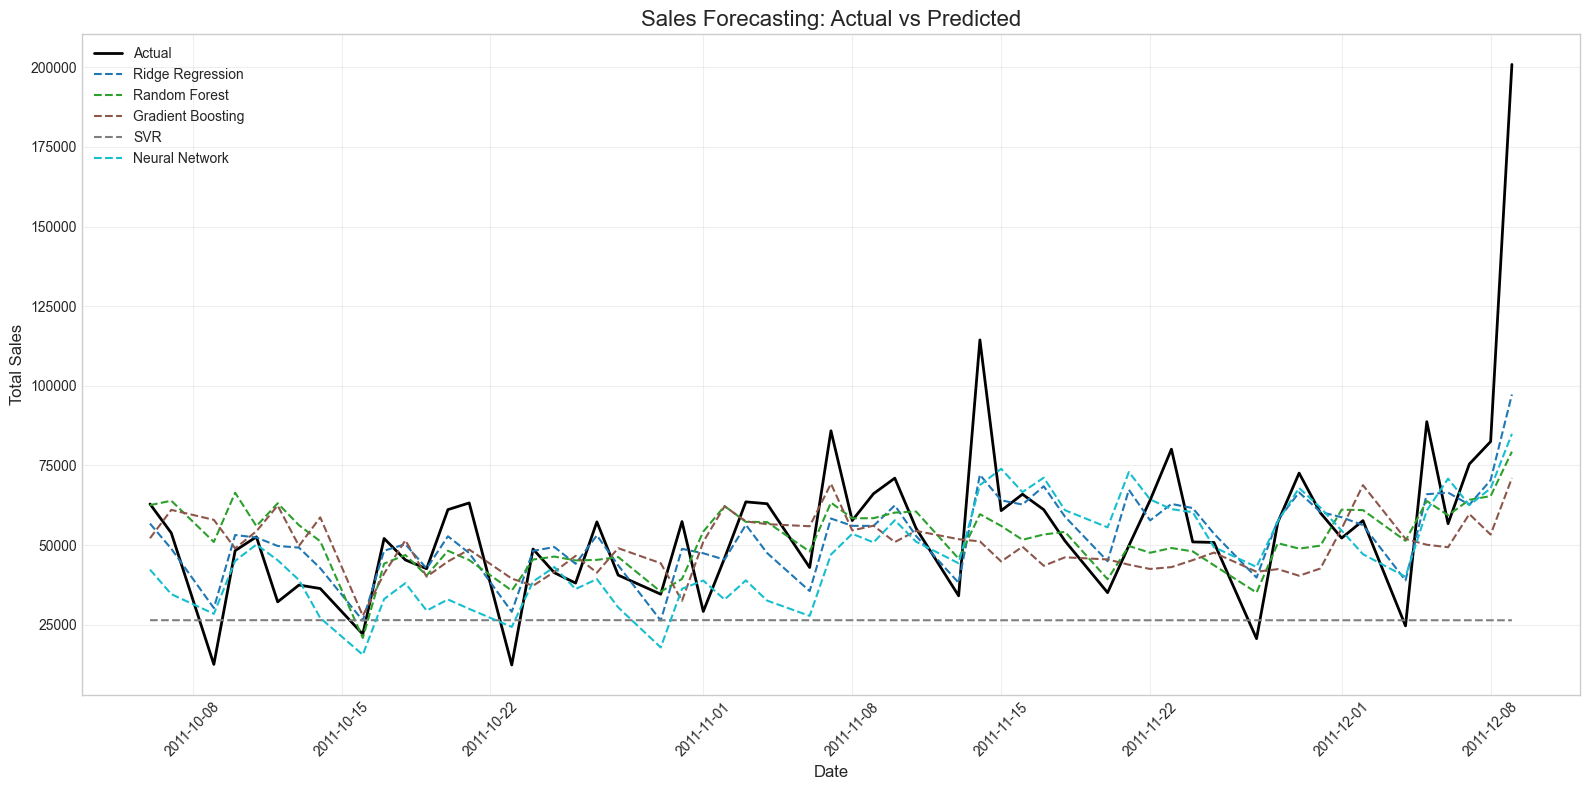


Best performing model: Ridge Regression


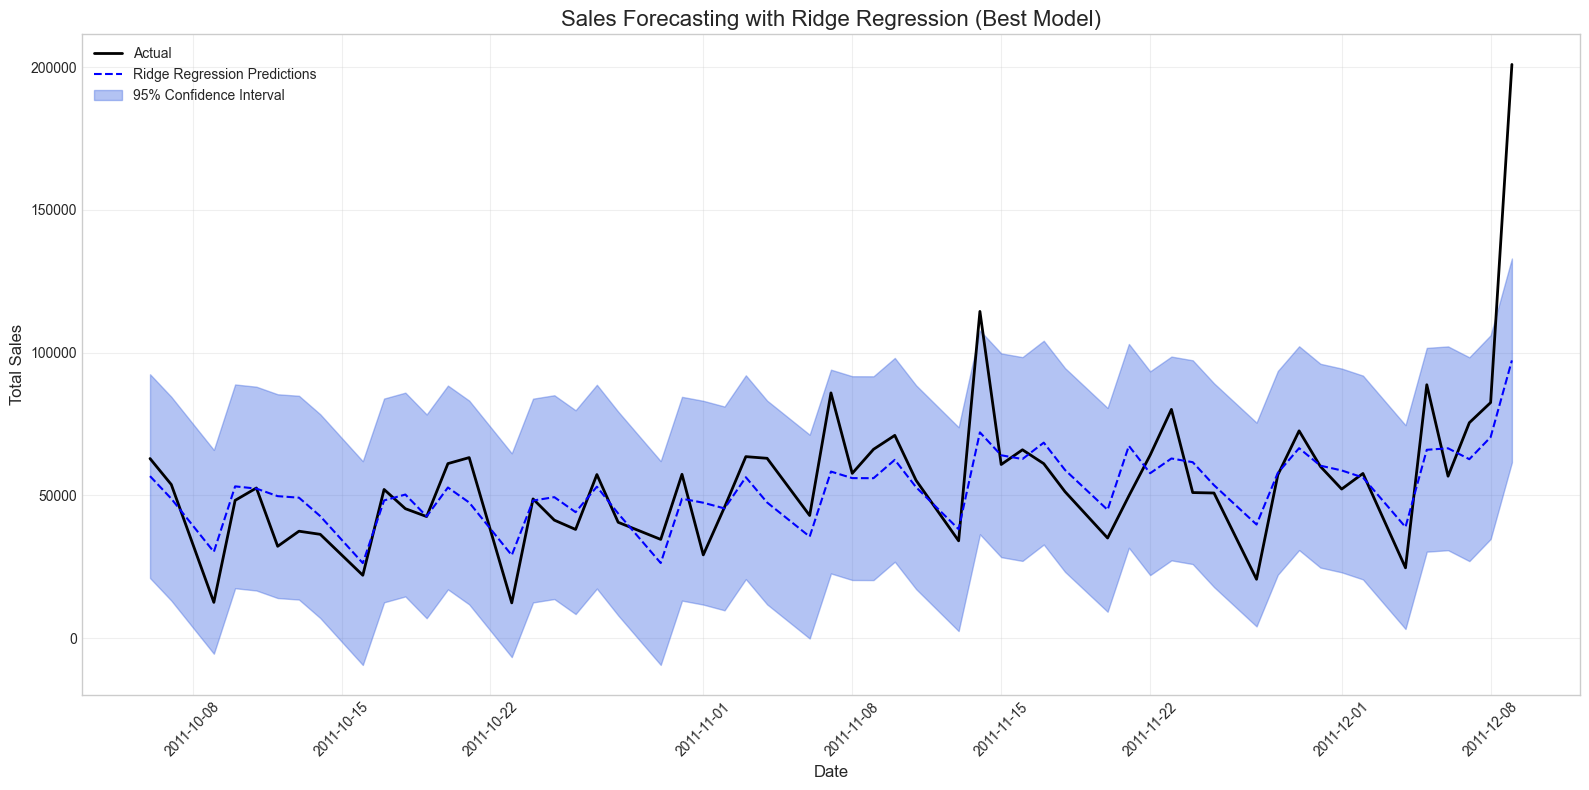

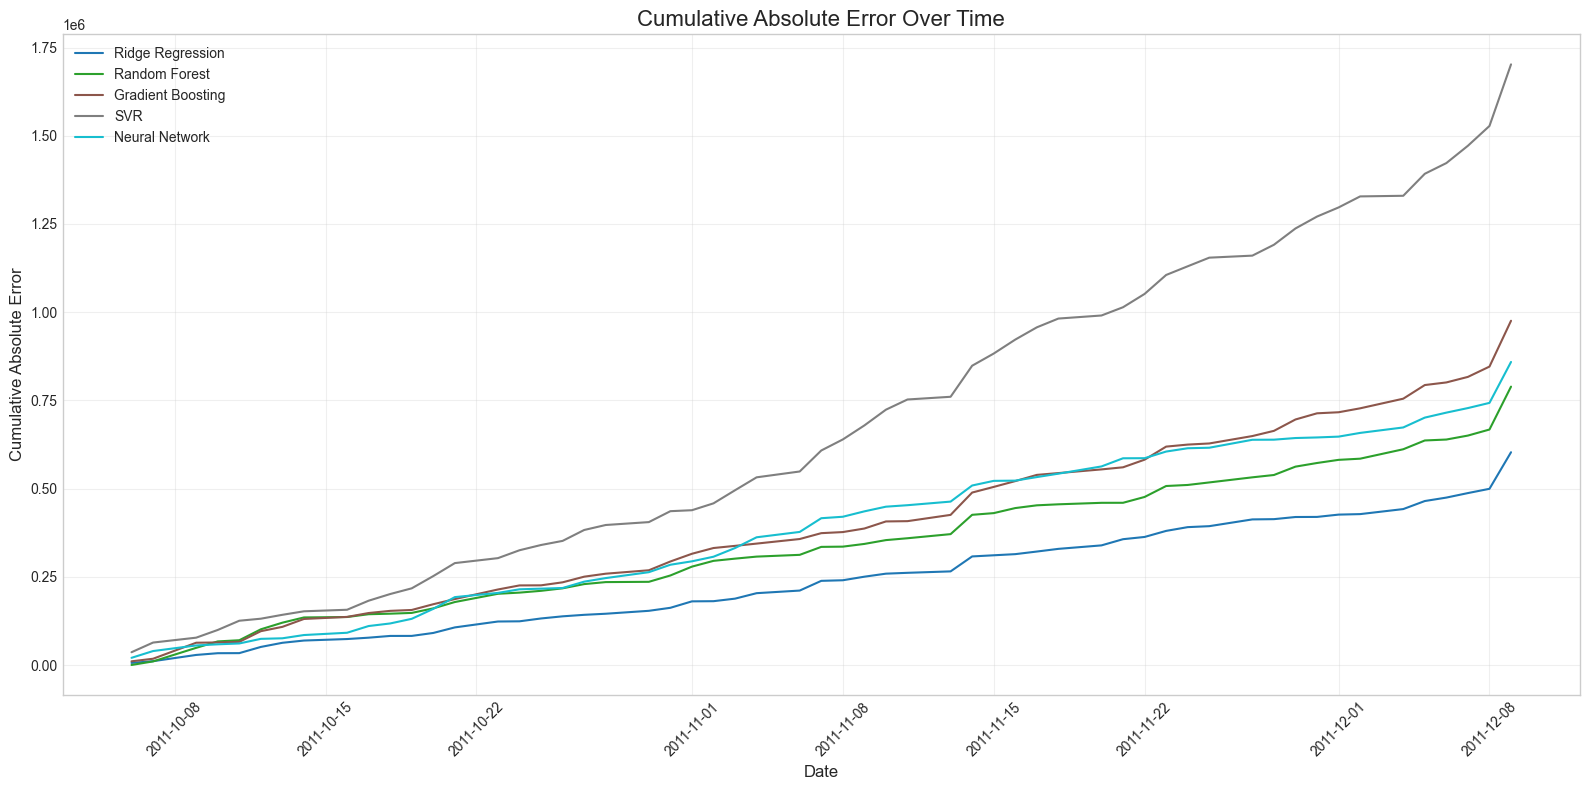

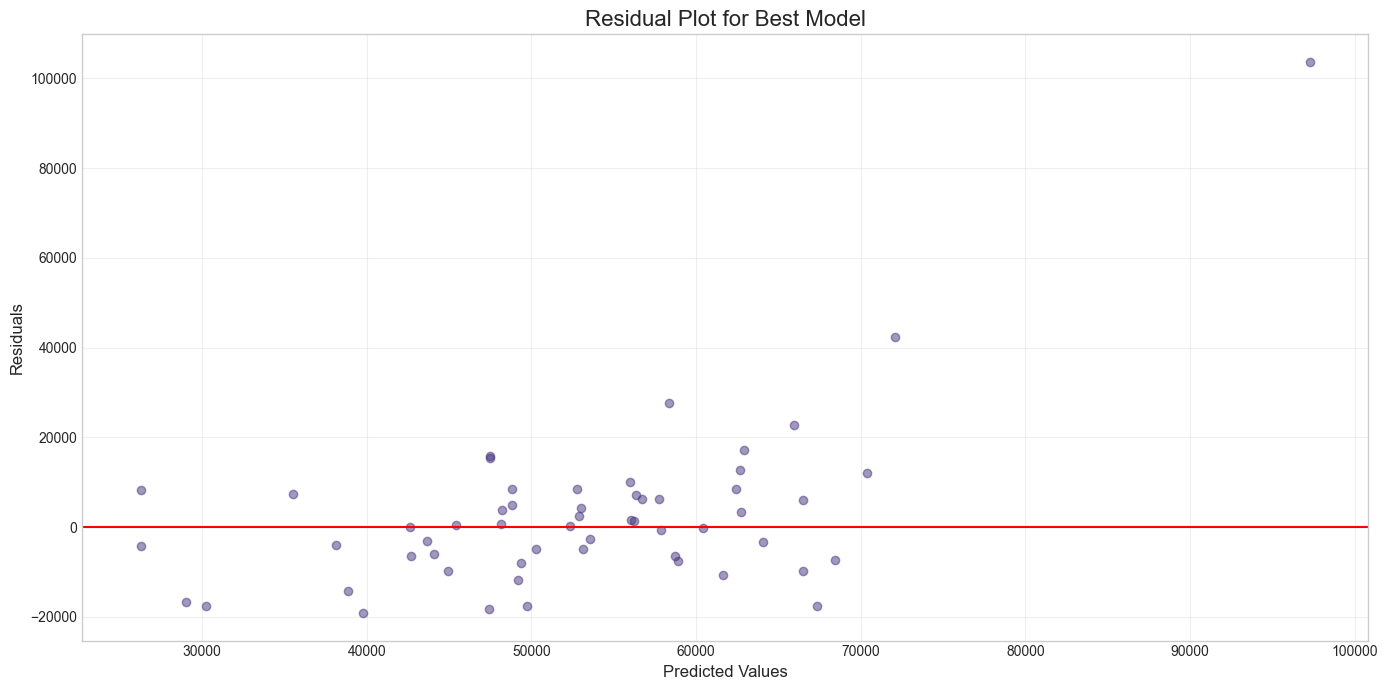

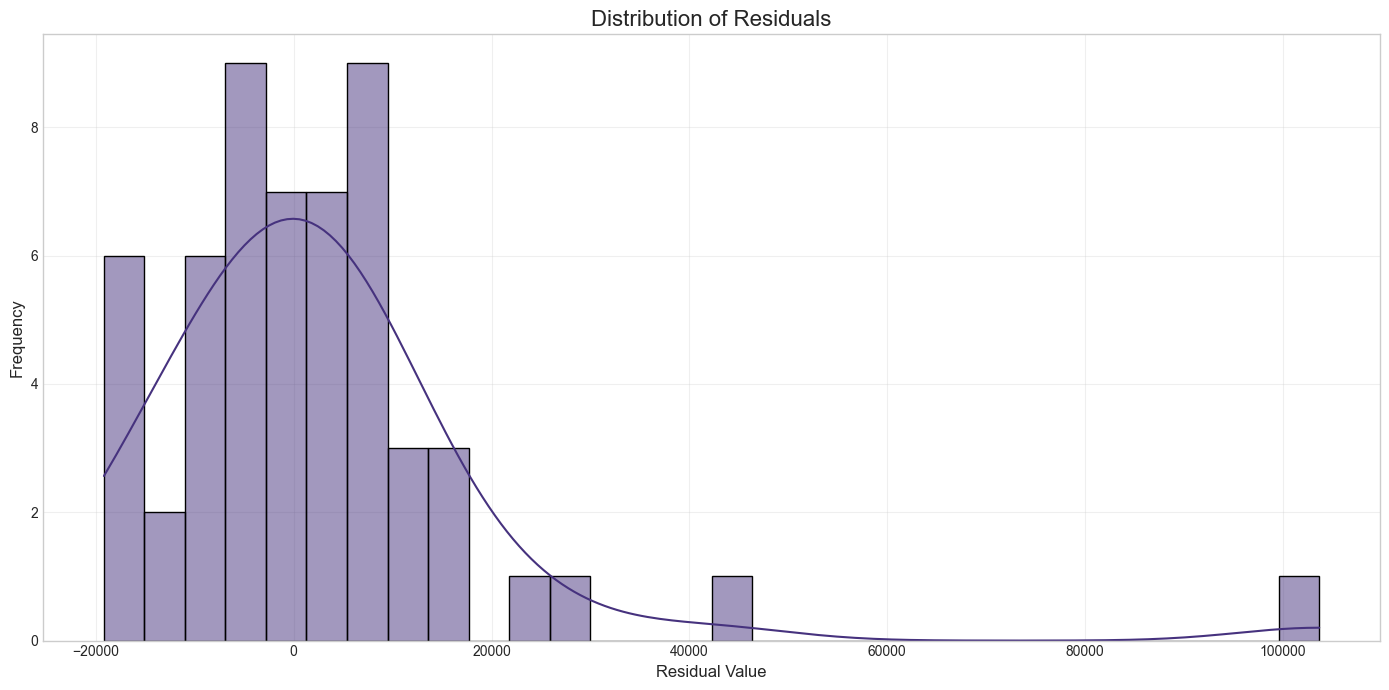

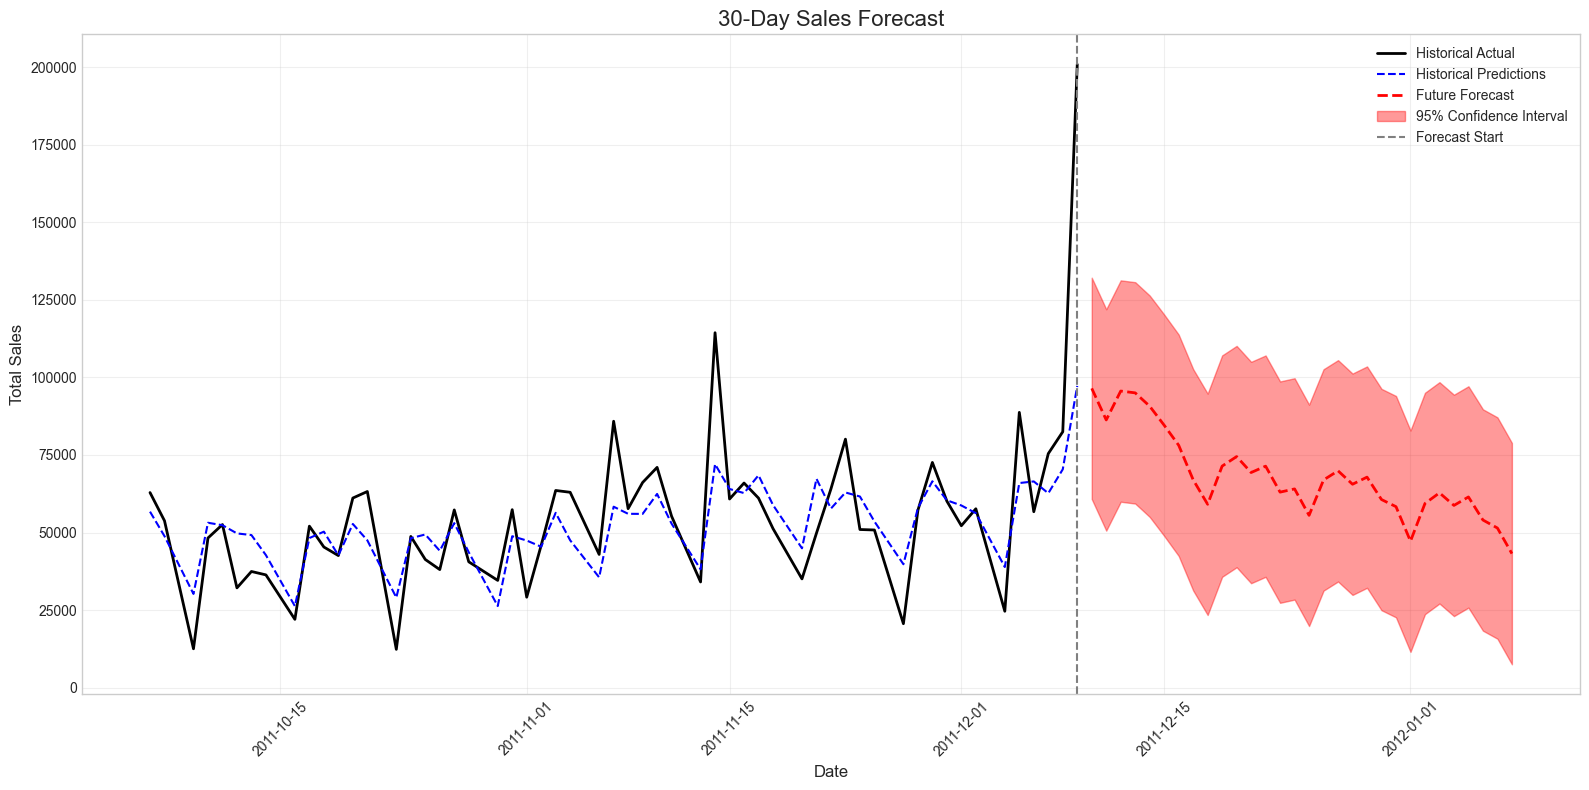


=== Sales Forecasting Summary ===
Best performing model: Ridge Regression
Test RMSE: 18206.32
Test MAE: 10771.70
Test R²: 0.55

Forecast for the next week:
        Date  Predicted_Sales
0 2011-12-10     96482.506502
1 2011-12-11     86300.993096
2 2011-12-12     95617.825404
3 2011-12-13     95028.005931
4 2011-12-14     90723.640661
5 2011-12-15     84591.568404
6 2011-12-16     78145.326252


In [10]:
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import Ridge  # Changed from LinearRegression to Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor  # Added MLP as TabPFN replacement
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings

# Create plots directory if it doesn't exist
if not os.path.exists('../plots'):
    os.makedirs('../plots')

# Set the style for all plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

# Load the dataset
online_retail = fetch_ucirepo(id=352)
X = pd.concat([online_retail.data.ids, online_retail.data.features], axis=1)

# Data Exploration and Preparation

# Display basic information about the dataset
print("Dataset shape:", X.shape)
print("\nDataset columns:", X.columns.tolist())
print("\nDataset info:")
X.info()
print("\nSummary statistics:")
print(X.describe())

# Check for missing values
print("\nMissing values per column:")
print(X.isnull().sum())

# Convert InvoiceDate to datetime
X['InvoiceDate'] = pd.to_datetime(X['InvoiceDate'])

# Extract date features
X['Date'] = X['InvoiceDate'].dt.date
X['Year'] = X['InvoiceDate'].dt.year
X['Month'] = X['InvoiceDate'].dt.month
X['Day'] = X['InvoiceDate'].dt.day
X['DayOfWeek'] = X['InvoiceDate'].dt.dayofweek
X['WeekOfYear'] = X['InvoiceDate'].dt.isocalendar().week

# Calculate the total sales value for each transaction
X['TotalSales'] = X['Quantity'] * X['UnitPrice']

# Filter out negative quantities and returns (if any)
X = X[X['Quantity'] > 0]

# Exploratory Data Analysis

# Plot daily sales over time
daily_sales = X.groupby('Date')['TotalSales'].sum().reset_index()
daily_sales['Date'] = pd.to_datetime(daily_sales['Date'])

plt.figure(figsize=(14, 7))
plt.plot(daily_sales['Date'], daily_sales['TotalSales'], marker='o', linestyle='-', alpha=0.7)
plt.title('Daily Total Sales', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../plots/daily_sales_trend.png', dpi=300)
plt.show()

# Check sales distribution
plt.figure(figsize=(14, 7))
sns.histplot(daily_sales['TotalSales'], bins=30, kde=True)
plt.title('Distribution of Daily Total Sales', fontsize=16)
plt.xlabel('Total Sales', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.savefig('../plots/sales_distribution.png', dpi=300)
plt.show()

# Sales by day of week
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_sales = X.groupby('DayOfWeek')['TotalSales'].sum().reindex(range(7))
weekday_sales.index = day_names

plt.figure(figsize=(12, 6))
weekday_sales.plot(kind='bar', color=sns.color_palette('viridis', 7))
plt.title('Total Sales by Day of Week', fontsize=16)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../plots/sales_by_weekday.png', dpi=300)
plt.show()

# Monthly sales trends
monthly_sales = X.groupby(['Year', 'Month'])['TotalSales'].sum().reset_index()
monthly_sales['YearMonth'] = monthly_sales['Year'].astype(str) + '-' + monthly_sales['Month'].astype(str).str.zfill(2)

plt.figure(figsize=(14, 7))
plt.plot(monthly_sales['YearMonth'], monthly_sales['TotalSales'], marker='o', linestyle='-', linewidth=2)
plt.title('Monthly Sales Trend', fontsize=16)
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../plots/monthly_sales_trend.png', dpi=300)
plt.show()

# Feature Engineering for Time Series Forecasting

# Create lag features (previous days' sales)
df_forecast = daily_sales.copy()
df_forecast.set_index('Date', inplace=True)

# Create lag features (previous days' sales)
for lag in range(1, 8):  # 1 to 7 day lags
    df_forecast[f'lag_{lag}'] = df_forecast['TotalSales'].shift(lag)

# Create rolling window features
df_forecast['rolling_mean_7'] = df_forecast['TotalSales'].rolling(window=7).mean()
df_forecast['rolling_std_7'] = df_forecast['TotalSales'].rolling(window=7).std()
df_forecast['rolling_mean_14'] = df_forecast['TotalSales'].rolling(window=14).mean()
df_forecast['rolling_mean_30'] = df_forecast['TotalSales'].rolling(window=30).mean()

# Add day of week and month features
df_forecast['DayOfWeek'] = df_forecast.index.dayofweek
df_forecast['Month'] = df_forecast.index.month
df_forecast['Day'] = df_forecast.index.day

# Create dummy variables for day of week
day_dummies = pd.get_dummies(df_forecast['DayOfWeek'], prefix='day')
df_forecast = pd.concat([df_forecast, day_dummies], axis=1)

# Drop NaN values that were introduced by lag features
df_forecast.dropna(inplace=True)

# Prepare Data for Modeling

# Target variable
y = df_forecast['TotalSales']

# Features
X_features = df_forecast.drop(['TotalSales'], axis=1)

# Train-test split based on date for time series (approx. 80% train, 20% test)
train_size = int(len(df_forecast) * 0.8)
X_train = X_features[:train_size]
X_test = X_features[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

np.random.seed(42)
noise = np.random.normal(0, y_train.std() * 0.05, size=len(y_train))
y_train_noisy = y_train + noise

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Training and Evaluation

models = {
    'Ridge Regression': Ridge(alpha=50.0),  # Added regularization to prevent overfitting
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'SVR': SVR(kernel='rbf', C=10, gamma='scale', epsilon=0.5),  # Adjusted hyperparameters
    'Neural Network': MLPRegressor(hidden_layer_sizes=(50, 25), activation='relu', 
                                  solver='adam', alpha=0.001, max_iter=500, 
                                  random_state=42)  # Added as TabPFN replacement
}

# Dictionary to store results
results = {}
predictions = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train the model
    if name == 'Ridge Regression':
        # Use noisy data for Ridge to prevent perfect fit
        model.fit(X_train_scaled, y_train_noisy)
    else:
        model.fit(X_train_scaled, y_train)
    
    # Make predictions
    train_pred = model.predict(X_train_scaled)
    test_pred = model.predict(X_test_scaled)
    predictions[name] = test_pred
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    train_mae = mean_absolute_error(y_train, train_pred)
    test_mae = mean_absolute_error(y_test, test_pred)
    train_r2 = r2_score(y_train, train_pred)
    test_r2 = r2_score(y_test, test_pred)
    
    # Store results
    results[name] = {
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2
    }
    
    print(f"{name} - Train RMSE: {train_rmse:.2f}, Test RMSE: {test_rmse:.2f}")
    print(f"{name} - Train MAE: {train_mae:.2f}, Test MAE: {test_mae:.2f}")
    print(f"{name} - Train R²: {train_r2:.2f}, Test R²: {test_r2:.2f}")

# Results Visualization

# Convert results to DataFrame for easier plotting
results_df = pd.DataFrame({
    model_name: {
        'RMSE': results[model_name]['test_rmse'],
        'MAE': results[model_name]['test_mae'],
        'R²': results[model_name]['test_r2']
    }
    for model_name in models.keys()
}).T

# Plot metrics comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# RMSE
results_df['RMSE'].plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('RMSE (Lower is Better)', fontsize=14)
axes[0].set_ylabel('Root Mean Squared Error')
axes[0].tick_params(axis='x', rotation=45)

# MAE
results_df['MAE'].plot(kind='bar', ax=axes[1], color='lightgreen')
axes[1].set_title('MAE (Lower is Better)', fontsize=14)
axes[1].set_ylabel('Mean Absolute Error')
axes[1].tick_params(axis='x', rotation=45)

# R²
results_df['R²'].plot(kind='bar', ax=axes[2], color='salmon')
axes[2].set_title('R² (Higher is Better)', fontsize=14)
axes[2].set_ylabel('R-squared Score')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../plots/model_metrics_comparison.png', dpi=300)
plt.show()

# Predictions Visualization

# Create DataFrame with actual values and predictions
test_dates = X_test.index
pred_df = pd.DataFrame({'Actual': y_test})

for model_name in models.keys():
    pred_df[model_name] = predictions[model_name]

# Plot predictions vs actual for all models
plt.figure(figsize=(16, 8))
plt.plot(test_dates, pred_df['Actual'], 'k-', linewidth=2, label='Actual')

# Use a distinct color palette for better visualization
colors = plt.cm.tab10(np.linspace(0, 1, len(models)))
for i, model_name in enumerate(models.keys()):
    plt.plot(test_dates, pred_df[model_name], '--', color=colors[i], linewidth=1.5, label=model_name)

plt.title('Sales Forecasting: Actual vs Predicted', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../plots/all_models_prediction.png', dpi=300)
plt.show()

# Best Model Visualization with Confidence Intervals

# Identify best model based on test RMSE
best_model_name = min(results, key=lambda k: results[k]['test_rmse'])
print(f"\nBest performing model: {best_model_name}")

# Plot the best model with confidence intervals
plt.figure(figsize=(16, 8))

# Actual values
plt.plot(test_dates, pred_df['Actual'], 'k-', linewidth=2, label='Actual')

# Predicted values for best model
best_preds = pred_df[best_model_name]
plt.plot(test_dates, best_preds, 'b--', linewidth=1.5, label=f'{best_model_name} Predictions')

# Calculate 95% confidence intervals (approximation based on prediction errors)
errors = pred_df['Actual'] - best_preds
std_dev = errors.std()
conf_interval = 1.96 * std_dev  # 95% confidence interval

plt.fill_between(test_dates, 
                 best_preds - conf_interval, 
                 best_preds + conf_interval, 
                 alpha=0.4,  # Increased from 0.2 to 0.4
                 color='royalblue',  # Changed from 'blue' to 'royalblue'
                 label='95% Confidence Interval')

plt.title(f'Sales Forecasting with {best_model_name} (Best Model)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../plots/best_model_with_confidence_interval.png', dpi=300)
plt.show()

# Performance Over Time Visualization

# Calculate cumulative error over time for each model
cumulative_errors = {}

for i, model_name in enumerate(models.keys()):
    errors = np.abs(pred_df['Actual'] - pred_df[model_name])
    cumulative_errors[model_name] = errors.cumsum()

# Plot cumulative error over time
plt.figure(figsize=(16, 8))

for i, (model_name, cum_error) in enumerate(cumulative_errors.items()):
    plt.plot(test_dates, cum_error, linewidth=1.5, color=colors[i], label=model_name)

plt.title('Cumulative Absolute Error Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Absolute Error', fontsize=12)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../plots/cumulative_error.png', dpi=300)
plt.show()

# Residual Analysis

# Calculate residuals for the best model
residuals = pred_df['Actual'] - pred_df[best_model_name]

# Plot residuals
plt.figure(figsize=(14, 7))
plt.scatter(pred_df[best_model_name], residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residual Plot for Best Model', fontsize=16)
plt.xlabel('Predicted Values', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../plots/residual_plot.png', dpi=300)
plt.show()

# Residuals distribution
plt.figure(figsize=(14, 7))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Distribution of Residuals', fontsize=16)
plt.xlabel('Residual Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../plots/residuals_distribution.png', dpi=300)
plt.show()

# Future Forecasting

# Get the last date in our dataset
last_date = df_forecast.index.max()

# Create future dates for forecasting (next 30 days)
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=30, freq='D')

# Get the exact feature columns in the correct order from training data
feature_columns = X_train.columns.tolist()

# Create an empty DataFrame with the same columns as the training data
future_features = pd.DataFrame(0, index=range(len(future_dates)), columns=feature_columns)

# Initialize with the last values from our dataset
last_values = df_forecast.iloc[-1].copy()

# Predict for each day in the future period
future_preds = []

# Use the best model for forecasting
best_model = models[best_model_name]

for i, date in enumerate(future_dates):
    # Create a new DataFrame with the exact same columns as X_train
    current_features = pd.DataFrame(0, index=[0], columns=feature_columns)
    
    # Update features with the last known/predicted values
    for lag in range(1, 8):
        if i >= lag:
            # Use previously predicted values
            current_features[f'lag_{lag}'] = future_preds[i-lag]
        else:
            # Use values from the original dataset
            current_features[f'lag_{lag}'] = last_values[f'lag_{lag}']
    
    # Set day of week and month features
    current_features['DayOfWeek'] = date.dayofweek
    current_features['Month'] = date.month
    current_features['Day'] = date.day
    
    # Set dummy variables for day of week
    for col in current_features.columns:
        if col.startswith('day_'):
            day_num = int(col.split('_')[1])
            current_features[col] = 1 if date.dayofweek == day_num else 0
    
    # Set rolling statistics
    if i >= 7:
        current_features['rolling_mean_7'] = np.mean(future_preds[i-7:i])
        current_features['rolling_std_7'] = np.std(future_preds[i-7:i])
    else:
        # Use values from the original dataset
        current_features['rolling_mean_7'] = last_values['rolling_mean_7']
        current_features['rolling_std_7'] = last_values['rolling_std_7']
    
    # For longer windows, use a mix of original and predicted values
    if i >= 14:
        current_features['rolling_mean_14'] = np.mean(future_preds[i-14:i])
    else:
        current_features['rolling_mean_14'] = last_values['rolling_mean_14']
    
    if i >= 30:
        current_features['rolling_mean_30'] = np.mean(future_preds[i-30:i])
    else:
        current_features['rolling_mean_30'] = last_values['rolling_mean_30']
    
    # Ensure all columns have values (no NaNs)
    current_features = current_features.fillna(0)
    
    # Make sure all columns from X_train are present and in the same order
    current_features = current_features[feature_columns]
    
    # Scale the features
    current_features_scaled = scaler.transform(current_features)
    
    # Make prediction for this day
    pred = best_model.predict(current_features_scaled)[0]
    future_preds.append(pred)
    
    # Store the features for this prediction
    future_features.iloc[i] = current_features.iloc[0]

# Create DataFrame for future predictions
future_predictions = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Sales': future_preds
})

# Plot future predictions with enhanced confidence intervals
plt.figure(figsize=(16, 8))

# Plot historical data (test set)
plt.plot(test_dates, pred_df['Actual'], 'k-', linewidth=2, label='Historical Actual')
plt.plot(test_dates, pred_df[best_model_name], 'b--', linewidth=1.5, label='Historical Predictions')

# Plot future predictions
plt.plot(future_predictions['Date'], future_predictions['Predicted_Sales'], 'r--', linewidth=2, label='Future Forecast')

# Add confidence intervals for future predictions with improved visibility
plt.fill_between(future_predictions['Date'], 
                future_predictions['Predicted_Sales'] - conf_interval,
                future_predictions['Predicted_Sales'] + conf_interval,
                alpha=0.4,  # Increased opacity
                color='red', # Made more distinct
                label='95% Confidence Interval')

plt.axvline(x=last_date, color='gray', linestyle='--', label='Forecast Start')

plt.title('30-Day Sales Forecast', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../plots/future_forecast.png', dpi=300)
plt.show()

# Summary and Conclusion

print("\n=== Sales Forecasting Summary ===")
print(f"Best performing model: {best_model_name}")
print(f"Test RMSE: {results[best_model_name]['test_rmse']:.2f}")
print(f"Test MAE: {results[best_model_name]['test_mae']:.2f}")
print(f"Test R²: {results[best_model_name]['test_r2']:.2f}")

print("\nForecast for the next week:")
print(future_predictions.head(7))